3 méthodes:
Pour découper le généric et le reportage
==> avoir la signature vocale + musicale ==> faire de la classification supervisée
en se basant sur des data externes labellisées speech vs musique
rajouter même une classe: silence (pour le dernier point)

Pour découper le reportage et le débat:
Travailler sur le bandeau ==> technique de détection de changement (nouveauté à base de distance)
Calculer la distance entre les histogrammes : passé vs future à chaque instant t
Mettre un treshold, au délà duquel, il y a un changement important d'image/ apparition du bandeau
Sinon, faire du clustering ==> détecter les plans qui appartiennent au même plan

La durée de l'intervention: dans le débat: intro + debat + conclusion

# Images

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [543]:
import seaborn as sns
sns.set()
%matplotlib inline

In [41]:
mypath='mroux/data/'

## FONCTIONS

### Génerer les histograms

In [19]:
def generate_histograms(mypath,ind_cut_image=0,split_blue=False):
    mean_array=[]
    var_array=[]
    diff_hist=[]
    histograms=[]
    temp_hist=np.zeros(256-ind_cut_image,int).reshape(-1,1)
    
    
    f = open(mypath+'listfull.txt', 'rt')
    for line in f:
        w = line.split()[0]
        img= cv2.imread(mypath+w)
        if not split_blue:
            img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img_show,g,r = cv2.split(img)
        hist = cv2.calcHist([img_show[ind_cut_image:]],[0],None,[256-ind_cut_image],[ind_cut_image,256])
    #     hist,bins = np.histogram(img_show[ind_cut_image:].ravel(),256,[0,256])
        
        diff=hist-temp_hist
        temp_hist=hist
        diff_hist.append(diff)
        histograms.append(hist)
        mean_array.append(np.mean(img_show[ind_cut_image:]))
        var_array.append(np.var(img_show[ind_cut_image:]))

    f.close()
    return histograms,mean_array,var_array

### Distance entre histogrammes

In [17]:
def distance_histograms(histograms):
    dist_bhattacharyya=[]
    intersect=[]
    correl=[]
    dist_chisquare=[]

    # for i,elem in enumerate(histograms):
    for i in range(len(histograms)-1):
        elemi=histograms[i]
        elemi1=histograms[i+1]
        
        chi_square=cv2.compareHist(elemi, elemi1,cv2.HISTCMP_CHISQR)
        BHATTACHARYYA=cv2.compareHist(elemi, elemi1, cv2.HISTCMP_BHATTACHARYYA)
        inters=cv2.compareHist(elemi, elemi1,cv2.HISTCMP_INTERSECT)
        cor=cv2.compareHist(elemi, elemi1,cv2.HISTCMP_CORREL)
        
        
        dist_chisquare.append(chi_square)
        dist_bhattacharyya.append(BHATTACHARYYA)
        intersect.append(inters)
        correl.append(cor)
        
    return dist_chisquare,dist_bhattacharyya,intersect,correl

### Plot an array (not image)

In [129]:
def show_plot_non_image(table,ind_start,ind_end):
    plt.plot(np.arange(ind_start,ind_end),table[ind_start:ind_end])
    plt.show()
def show_plot_non_image_range(table,array_range):
    plt.plot(array_range,table)
    plt.show()

### Plot an image

In [39]:
def plot_image(mypath,image,ind_start):
    img= cv2.imread(mypath+image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img,g,r = cv2.split(img)
    plt.imshow(img[ind_start:])

### Run all: Histograms+Distance

In [20]:
def run_all(mypath,ind_cut_image=200,split_blue=False):
    hists,mean_array,var_array=generate_histograms(mypath,ind_cut_image,split_blue)
    dist_chisquare,dist_bhattacharyya,intersect,correl=distance_histograms(hists)
    return dist_chisquare,dist_bhattacharyya,intersect,correl,mean_array,var_array

#### GET THE GOOD IMAGE

In [329]:
def index_image_start_debat(dist,lenght_video,threshold_to_max_dist):
    # get the half of the video
    len_half=int(len(dist)*lenght_video)
    
    dist=np.array(dist)
    
    if np.max(dist)/np.median(dist)>=10000:
        dist[dist>=np.max(dist)]=0
    
    threshold=np.max(dist[:len_half])*threshold_to_max_dist
   
    list_index=np.where(dist[:len_half]>threshold)
    the_image_index=list_index[0][-1]+2
    return list_index[0],the_image_index

def index_image_start_debat_correl(dist,lenght_video,threshold_to_max_dist,correl,corr_range):
    # get the half of the video
    len_half=int(len(dist)*lenght_video)
    
    dist=np.array(dist)
    if corr_range!=1:
        get_index_correl=np.array(np.where((np.array(correl)<=corr_range)&(np.array(correl)>=-corr_range)))[0]
        dist=np.array([dist[elem] if elem in get_index_correl else 0 for elem,_ in enumerate(dist)])
    
    if np.median(dist)==0:
        if np.max(dist)/np.mean(dist)>=100:
            dist[dist>=np.max(dist)]=0
    elif np.max(dist)/np.median(dist)>=10000:
        dist[dist>=np.max(dist)]=0
        
    
    threshold=np.max(dist[:len_half])*threshold_to_max_dist
   
    list_index=np.where(dist[:len_half]>threshold)
    the_image_index=list_index[0][-1]+2
    return list_index[0],the_image_index

def plot_choosen_image(mypath,the_image_index):
    #lenth of the iamge name =8 (without the .jpg) ==> len('00001619.jpg'.split(".")[0])
    str_zero=8-len(str(the_image_index))
    image_name=str_zero*"0"+str(the_image_index)+".jpg"
    plot_image(mypath,image_name,0)

In [573]:
def plot_mea_variance(mean_array,thresh_mean=150,ind_start=0,ind_end=2350,len_video=0.4):
    max_len=int(len(mean_array)*len_video)
    diff_mean=np.array([mean_array[i]-mean_array[i-1] for i in range(1,len(mean_array))])[:max_len]
    diff_mean[(diff_mean<thresh_mean)&(diff_mean>-thresh_mean)]=0
    print(np.where(diff_mean!=0))
    plt.plot(diff_mean[ind_start:ind_end])

## RUN

##### Hypothèse  1: on sait où il est le bandeau, on coupe les images pour ne garder que la partie basse (à partir de index=200)

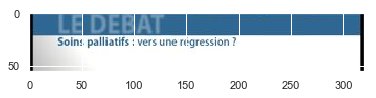

In [544]:
ind_cut_image=200
split_blue=True
dist_chisquare1,dist_bhattacharyya1,intersect1,correl1,mean_array1,var_array1=run_all(mypath,ind_cut_image,split_blue)
plot_image(mypath,'00000086.jpg',ind_cut_image)

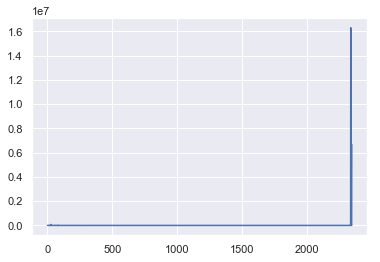

In [550]:
show_plot_non_image(dist_chisquare1,0,2350) #max = 2350 (=#nombre d'images)

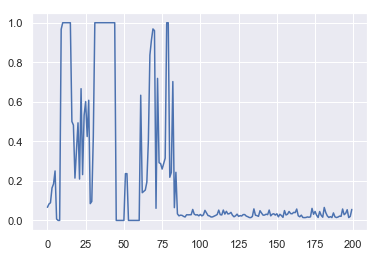

In [546]:
show_plot_non_image(dist_bhattacharyya1,0,200)

Index images avec détection changement, sans prendre en compte correl (-2) [ 9 10 11 27 30 61 84]


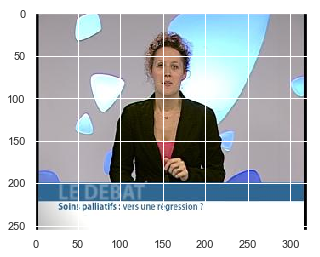

Index images avec détection changement,fonction avec correl (-2) [9]


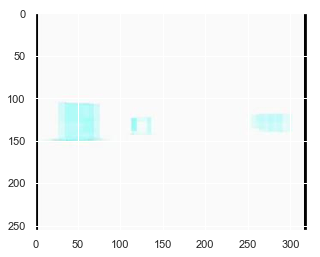

In [548]:
index_,the_image_index1=index_image_start_debat(dist_chisquare1,lenght_video=0.2,threshold_to_max_dist=0.2)
plot_choosen_image(mypath,the_image_index1)
print("Index images avec détection changement, sans prendre en compte correl (-2)",index_)
plt.show()
index_,the_image_index2=index_image_start_debat_correl(dist_chisquare1,lenght_video=0.2,threshold_to_max_dist=0.2,\
                                                      correl=correl1,corr_range=0.02)
plot_choosen_image(mypath,the_image_index2)
print("Index images avec détection changement,fonction avec correl (-2)",index_)

In [ ]:
Conclusion:
    Avec split_blue=False
    Fonction sans correl: image: 86 ==> index=84 + 2 pour avoir le nom de l'image
    Fonction avec correl: image: 12
            
    Sans split_blue=True
    Fonction sans correl: image: 86
    Fonction avec correl: image: 12 

##### Hypothèse  2 conservatrice: on ne sait pas où il est le bandeau exactement, on dit que 40% de l'image est dédiée au bandeau : à partir de pixel=153

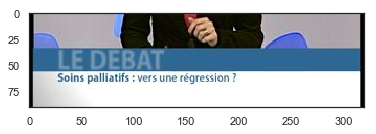

In [602]:
ind_cut_image2=int(0.65*256)
split_blue=True
dist_chisquare2,dist_bhattacharyya2,intersect2,correl2,mean_array2,var_array2=run_all(mypath,ind_cut_image2,split_blue)
plot_image(mypath,'00000086.jpg',ind_cut_image2)

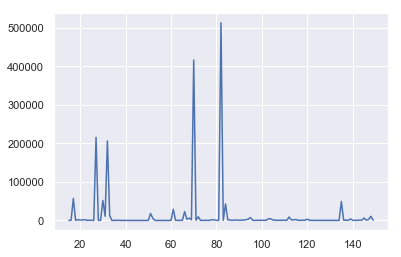

In [609]:
sns.set()
show_plot_non_image(dist_chisquare2,15,150) #max = 2350 (=#nombre d'images) (50%*2350=1175)
# show_plot_non_image(dist_bhattacharyya2,0,100)

##### Récupérer l'image trouvé ==> Not good

Index images avec détection changement, sans prendre en compte correl [ 27  32  70  84 135 155 173 294 403 453]


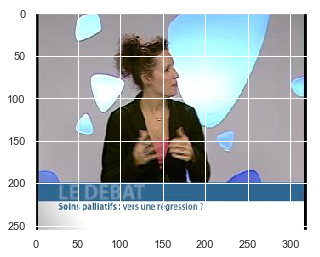

Index images avec détection changement,fonction avec correl [10]


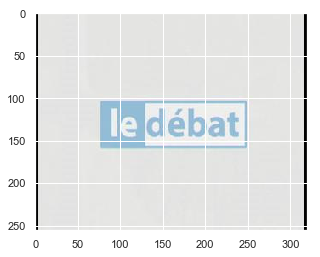

In [554]:
index_,the_image_index=index_image_start_debat(dist_chisquare2,lenght_video=0.2,threshold_to_max_dist=0.2)
plot_choosen_image(mypath,the_image_index)
print("Index images avec détection changement, sans prendre en compte correl",index_)
plt.show()
index_,the_image_index=index_image_start_debat_correl(dist_chisquare2,lenght_video=0.2,threshold_to_max_dist=0.2,\
                                                      correl=correl1,corr_range=0.05)
plot_choosen_image(mypath,the_image_index)
print("Index images avec détection changement,fonction avec correl",index_)

In [ ]:
Conclusion:
    Avec split_blue=True
    Fonction sans correl: image: 84 ==> index=80 + 2 pour avoir le nom de l'image
    Fonction avec correl: image: 12
            
    Sans split_blue=False
    Fonction sans correl: image: 455
    Fonction avec correl: image: 12 

##### Hypothèse  3: Prendre toute l'image

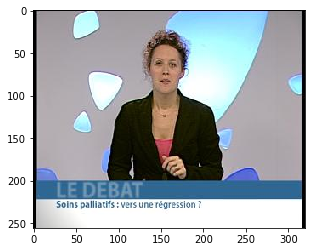

In [520]:
ind_cut_image3=0
split_blue=True
dist_chisquare3,dist_bhattacharyya3,intersect3,correl3,mean_array3,var_array3=run_all(mypath,ind_cut_image3,split_blue)
plot_image(mypath,'00000086.jpg',ind_cut_image3)

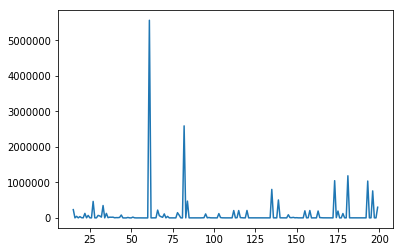

In [521]:
show_plot_non_image(dist_chisquare3,15,200) #max = 2350 (=#nombre d'images) (50%*2350=1175)
# show_plot_non_image(correl3,0,200)

##### Récupérer l'image trouvé ==> Not good

Index images avec détection changement, sans prendre en compte correl [  0   9  12  61  82 181]


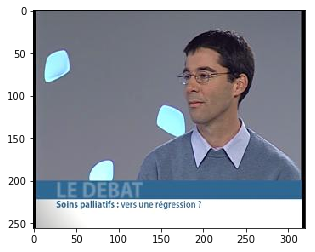

Index images avec détection changement,fonction avec correl [ 9 82]


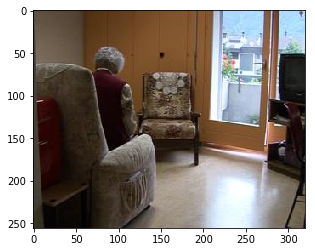

In [524]:
index_,the_image_index=index_image_start_debat(dist_chisquare3,lenght_video=0.2,threshold_to_max_dist=0.2)
plot_choosen_image(mypath,the_image_index)
print("Index images avec détection changement, sans prendre en compte correl",index_)
plt.show()
index_,the_image_index=index_image_start_debat_correl(dist_chisquare3,0.2,0.2,correl3,0.05)
plot_choosen_image(mypath,the_image_index)
print("Index images avec détection changement,fonction avec correl",index_)

(array([11, 12, 15, 33, 44, 61, 84], dtype=int64),)


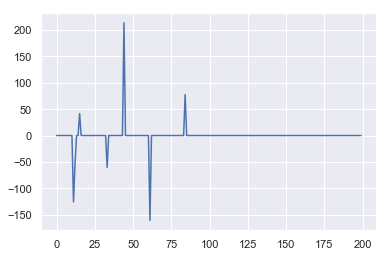

(array([ 66,  82, 135, 598, 629, 630], dtype=int64),)


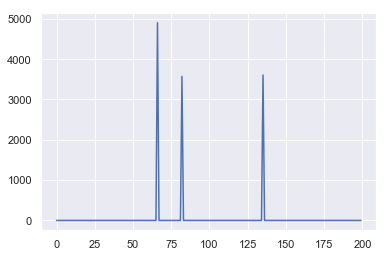

In [575]:
plot_mea_variance(mean_array3,thresh_mean=40,ind_start=0,ind_end=200,len_video=0.4) #Plotting the difference between two means that are >=30 threshold)
plt.show()
plot_mea_variance(var_array3,3500,0,200,len_video=0.4)
# How to get the right thresh_mean?

In [ ]:
Conclusion: ==> Not good
    Avec split_blue=True
    Fonction sans correl: image: 183 ==> index=181 + 2 pour avoir le nom de l'image
    Fonction avec correl: image: 84
            
    Sans split_blue=False
    Fonction sans correl: image: 63
    Fonction avec correl: image: 63 

## Gradient

Si on ne prend que le bas de l'image ==> le bandeau, à partir de 200 pixel ==> Bon résultat

In [558]:
ind_cut_image2=int(0.65*256)

166

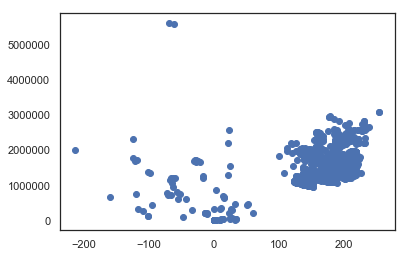

In [590]:
ind=int(0.65*256)

mean_array=[]
var_array=[]
temp_hist=np.zeros(256-ind).reshape(-1,1)
# temp_hist=np.zeros(256).reshape(-1,1)
diff_hist=[]
histograms=[]


f = open('mroux/data/listfull.txt', 'rt')
for line in f:
    w = line.split()[0]
    img= cv2.imread('mroux/data/'+w)
    img,g,r = cv2.split(img)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5) #GRADIENT
#     edges = cv2.Canny(img,400,400) #ça ne donne pas de bon résultats
    mean_array.append(np.mean(sobely[ind:]))
    var_array.append(np.var(sobely[ind:]))

f.close()
plt.scatter(mean_array,var_array)

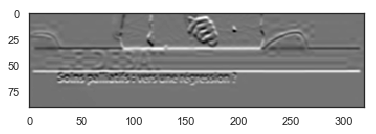

In [601]:
img= cv2.imread(mypath+'00000086.jpg',cv2.IMREAD_COLOR)
img,g,r = cv2.split(img)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5) #GRADIENT
sns.set_style("white")
plt.imshow(sobely[ind:],cmap="gray")

(array([  22,   31,   79,   82,   84, 1758, 1949, 1952, 1989, 1991, 2293,
       2295, 2340], dtype=int64),)


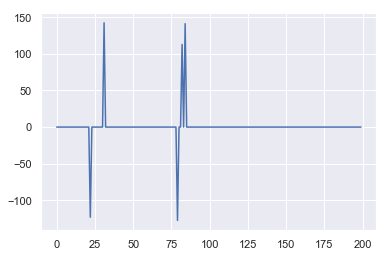

(array([   0,    1,    2, ..., 2347, 2348, 2349], dtype=int64),)


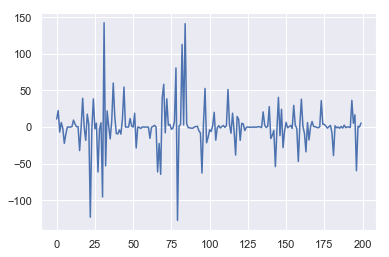

(array([ 17,  19,  31,  32,  33,  70,  72,  78, 306, 316, 319, 731, 734,
       735, 738, 828, 832, 838, 841], dtype=int64),)


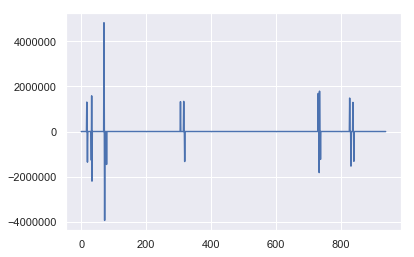

In [600]:
sns.set()
plot_mea_variance(mean_array,thresh_mean=100,ind_start=0,ind_end=200,len_video=1) #Plotting the difference between two means that are >=30 threshold)
plt.show()
plot_mea_variance(mean_array,thresh_mean=0,ind_start=0,ind_end=200,len_video=1)
plt.show()
plot_mea_variance(var_array,1200000,0,int(len(var_array)*0.4),len_video=0.4)
# How to get the right thresh_mean?